In [1]:
# initialize google drive
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


## Dependences

In [ ]:
# Installing dependences
# !pip install -qq sentence-transformers

In [2]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

## Libraries

In [3]:
# %matplotlib inline
import argparse
import pickle
import os
import re
import random
import torch
import math
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision import utils
import torchvision.datasets as daset
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import pandas as pd
from itertools import cycle
from torchtext.data import get_tokenizer
from torch.nn.utils.rnn import pad_sequence

# Create the tokenizer
tokenizer = get_tokenizer("basic_english")

## Hyperparameters

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Cover path
cover_path = "/content/drive/MyDrive/Fast-Dreambooth/Sessions/coverart/instance_images"

# Caption path
caption_path = "/content/drive/MyDrive/Fast-Dreambooth/Sessions/coverart/captions"

# num classes
num_classes = 20

# Saving directory
save_dir = (
    "/content/drive/MyDrive/cover-art-generation/artifacts/conditioned_dcgan_weights/"
)

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 300

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of validation samples
num_val_samples = 64

# Process text flag
process_text = True

## Data Loading
### Vocab definition

In [6]:
with open(f"{save_dir}captions.pickle", "rb") as file:
    captions = pickle.load(file)
    file.close()

# Regular expression pattern for special characters
special_chars_pattern = re.compile(r"[^a-zA-Z0-9]")

# Tokenize the captions and create the vocabulary
vocab = []
for caption in captions:
    caption = caption.split("and audio features")[0]
    tokens = tokenizer(caption.lower())

    if process_text:
        tokens = [
            special_chars_pattern.sub("", token) for token in tokens if token.isascii()
        ]
    vocab.extend(tokens)

# Remove duplicate tokens and sort the vocabulary
vocab = sorted(set(vocab))

# Convert the vocabulary to a dictionary
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Example usage:
print("Vocabulary Size:", len(vocab))

Vocabulary Size: 27655


### DataLoader

In [7]:
class TextToImageDataset(Dataset):
    def __init__(self, image_folder, caption_folder, transform=None, process_text=True):
        self.image_folder = image_folder
        self.caption_folder = caption_folder
        self.transform = transform
        self.captions = os.listdir(self.caption_folder)
        self.process_text = process_text

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_name = caption.split(".")[0]
        image_path = os.path.join(self.image_folder, f"{image_name}.jpeg")
        caption_path = os.path.join(self.caption_folder, caption)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(caption_path, "r") as file:
            caption = file.read().strip()
            caption = caption.split("and audio features")[0].strip()

            if self.process_text:
                caption = tokenizer(caption.lower())
                caption = " ".join(
                    [
                        special_chars_pattern.sub("", token)
                        for token in caption
                        if token.isascii()
                    ]
                )

        return image, caption

In [9]:
# Create the transform object
transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Create the dataset
dataset = TextToImageDataset(
    cover_path, caption_path, transform=transform, process_text=process_text
)

# Create the dataloader
dataloader = DataLoader(
    dataset, batch_size=batch_size, shuffle=True, num_workers=workers
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=2, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# DCGAN

## Generador

In [10]:
class ConditionalGenerator(torch.nn.Module):
    def __init__(
        self, noise_size: int, num_input_channels: int, num_classes: int
    ) -> None:
        super().__init__()

        # Create the Fully connected layer using nn.Linear
        self.fc = nn.Linear(noise_size, 512 * 8 * 8)

        self.embedding = nn.EmbeddingBag(
            num_embeddings=num_classes, embedding_dim=8 * 8, mode="sum"
        )

        # Create the first block
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512 + 1,
                out_channels=256,
                kernel_size=4,
                padding=1,
                stride=2,
                bias=False,
            ),  # (B, 256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        # Create the second block
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256,
                out_channels=128,
                kernel_size=4,
                padding=1,
                stride=2,
                bias=False,
            ),  # (B, 128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Create the third block using nn.Sequential with ConvTranspose2d, and activation
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128,
                out_channels=num_input_channels,
                kernel_size=4,
                padding=1,
                stride=2,
                bias=False,
            ),  # (B, num_input_channels, 64, 64)
            nn.Tanh(),
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:
        # Define the forward of the generator, x are random noise vectors (B, noise_size)
        x = self.fc(x)
        x = x.reshape(-1, 512, 8, 8)  # (B, channels, height, width)
        emb = self.embedding(label).reshape(
            -1, 1, 8, 8
        )  # (B, 1 - channel, height, width)
        x = torch.cat((x, emb), dim=1)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)

        return x

## Discriminador

In [11]:
class ConditionalDiscriminator(torch.nn.Module):
    def __init__(self, num_input_channels: int, num_classes: int):
        super().__init__()

        self.embedding = nn.EmbeddingBag(
            num_embeddings=num_classes, embedding_dim=ndf * ndf, mode="sum"
        )

        # Create the first block
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=num_input_channels + 1,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 128, 32, 32)
            nn.LeakyReLU(0.2),
        )

        # Create the second block
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 256, 16, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        # Create the third block
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),  # (B, 512, 8, 8)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Create the fully connected block using nn.Sequential with Linear and activation
        self.fc = nn.Sequential(
            nn.Linear(in_features=512 * 8 * 8, out_features=1),
            nn.Sigmoid(),  # Binary classification (real vs false)
        )

    def forward(self, x: torch.Tensor, label: int) -> torch.Tensor:
        # Define the forward of the discriminator, x are images (B, num_input_channels, ndf, ndf)
        emb = self.embedding(label).reshape(-1, 1, ndf, ndf)  # (B, 1, ndf, ndf)
        x = torch.cat([x, emb], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(-1, 512 * 8 * 8)  # (B, channels * height * width)
        x = self.fc(x)

        return x

In [12]:
# generator = ConditionalGenerator(nz, nc, num_classes).to(device)
generator = ConditionalGenerator(nz, nc, len(vocab)).to(device)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

# Handle multi-GPU if desired
if (device.type == "cuda") and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))

# discriminator = ConditionalDiscriminator(nc, num_classes).to(device)
discriminator = ConditionalDiscriminator(nc, len(vocab)).to(device)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Handle multi-GPU if desired
if (device.type == "cuda") and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

criterion = nn.BCELoss()


def init_weights(m):
    if type(m) in {nn.Conv2d, nn.ConvTranspose2d, nn.Linear}:
        torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias != None:
            torch.nn.init.constant_(m.bias, 0.0)
    if type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [13]:
generator.apply(init_weights)

ConditionalGenerator(
  (fc): Linear(in_features=100, out_features=32768, bias=True)
  (embedding): EmbeddingBag(27655, 64, mode='sum')
  (convt1): Sequential(
    (0): ConvTranspose2d(513, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): Tanh()
  )
)

In [14]:
discriminator.apply(init_weights)

ConditionalDiscriminator(
  (embedding): EmbeddingBag(27655, 4096, mode='sum')
  (conv1): Sequential(
    (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=32768, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

## Training

In [15]:
def train_batch_conditional(
    real_samples: torch.Tensor,
    real_classes: torch.Tensor,
    generator: torch.nn.Module,
    discriminator: torch.nn.Module,
    optimizer_g: torch.optim,
    optimizer_d: torch.optim,
):
    generator.train()
    discriminator.train()

    bsz = real_samples.shape[0]
    bsz1 = real_samples.shape[1]

    # Define the labels for the real (ones) and fake (zeros) images of size (bsz, 1)
    label_real = torch.ones(bsz, 1)
    label_fake = torch.zeros(bsz, 1)

    label_real = label_real.to(device)
    label_fake = label_fake.to(device)

    ####################
    # OPTIMIZE GENERATOR
    ####################

    # Reset gradients
    optimizer_g.zero_grad()

    # Generate fake samples
    z = torch.randn(bsz, nz, device=device)
    fake_classes = torch.randint(0, len(vocab), size=(bsz, bsz1), device=device)
    fake_samples = generator(z, real_classes)

    # Evaluate the generated samples with the discriminator
    predictions_g_fake = discriminator(fake_samples, real_classes)

    # Calculate error with respect to what the generator wants
    loss_g = criterion(predictions_g_fake, label_real)

    # Backpropagate
    loss_g.backward()

    # Update weights
    optimizer_g.step()

    ########################
    # OPTIMIZE DISCRIMINATOR
    ########################

    fake_samples = fake_samples.detach()

    # Reset gradients
    optimizer_d.zero_grad()

    # Calculate discriminator prediction for real samples
    predictions_d_real = discriminator(real_samples, real_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_real = criterion(predictions_d_real, label_real)

    # Calculate discriminator loss for fake samples
    predictions_d_fake = discriminator(fake_samples, real_classes)

    # Calculate error with respect to what the discriminator wants
    loss_d_fake = criterion(predictions_d_fake, label_fake)

    # Total discriminator loss
    loss_d = (loss_d_real + loss_d_fake) / 2

    # Backpropagate
    loss_d.backward()

    # Update weights
    optimizer_d.step()

    return loss_g.item(), loss_d.item()

### Evaluate function

In [16]:
@torch.no_grad()
def evaluate_conditional(
    generator: torch.nn.Module,
    z_val: torch.Tensor,
    labels_val: torch.Tensor,
) -> Image.Image:
    generator.eval()
    fake_samples = generator(z_val, labels_val).cpu()
    # select a sample or create grid if img is a batch
    nrows = int(math.sqrt(fake_samples.shape[0]))
    img = utils.make_grid(fake_samples, nrow=nrows)

    # unnormalize
    img = (img * 0.5 + 0.5) * 255

    # to numpy
    image_numpy = img.numpy().astype(np.uint8)
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    return Image.fromarray(image_numpy)

### Training loop

In [17]:
# create the validation instances to evaluate model performance during training

z_val = torch.randn(num_val_samples, nz, device=device)
prompt_val = captions[:num_val_samples]

prompt_val = [tokenizer(text.lower()) for text in prompt_val]
prompt_val = [
    " ".join(
        [special_chars_pattern.sub("", token) for token in tokens if token.isascii()]
    )
    for tokens in prompt_val
]
prompt_val = [text.split("and audio features")[0].strip() for text in prompt_val]
prompt_val = [
    torch.tensor([vocab.index(word) for word in tokenizer(text)]) for text in prompt_val
]
padded_prompt_val = pad_sequence(prompt_val, batch_first=True, padding_value=0)
padded_prompt_val = padded_prompt_val.to(device)

In [19]:
# uncomment this line if you want to load the saved checkpoint

# checkpoint = torch.load(f"{save_dir}checkpoint.pt")
# print(checkpoint.keys())

# epoch = checkpoint["epoch"]

# generator.load_state_dict(checkpoint["generator_dict"])
# discriminator.load_state_dict(checkpoint["discriminator_dict"])

# optimizer_g.load_state_dict(checkpoint["optimizer_g_state_dict"])
# optimizer_d.load_state_dict(checkpoint["optimizer_d_state_dict"])

31

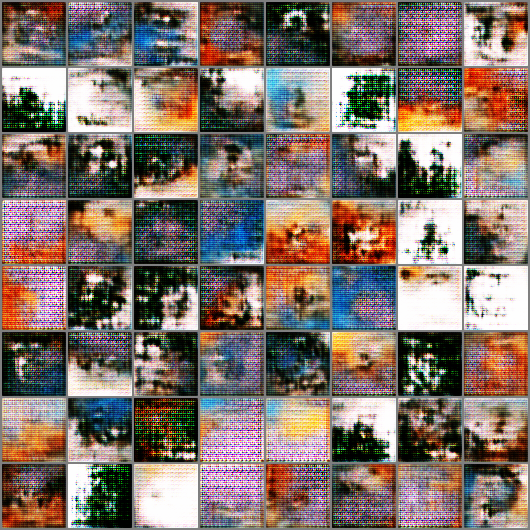

In [20]:
# print start point images
fake_images = evaluate_conditional(generator, z_val, padded_prompt_val)
display(fake_images)

In [ ]:
# start training
g_losses = []
d_losses = []

for epoch in range(num_epochs):
    for i, (real_samples, real_classes) in enumerate(dataloader):
        real_samples = real_samples.to(device)

        real_classes_indices = [
            torch.tensor([vocab.index(word) for word in tokenizer(text)])
            for text in real_classes
        ]
        padded_real_classes_indices = pad_sequence(
            real_classes_indices, batch_first=True, padding_value=0
        )

        padded_real_classes_indices = padded_real_classes_indices.to(device)

        loss_g, loss_d = train_batch_conditional(
            real_samples,
            padded_real_classes_indices,
            generator,
            discriminator,
            optimizer_g,
            optimizer_d,
        )

        g_losses.append(loss_g)
        d_losses.append(loss_d)

        if (i + 1) % 100 == 0:
            print(
                f"\nEpoch: {epoch + 1} / {num_epochs}, batch: {i + 1} / {len(dataloader)},"
                + f" G_loss: {loss_g}, D_loss: {loss_d}"
            )

            g_loss_path = f"{save_dir}/g_loss.pkl"
            d_loss_path = f"{save_dir}/d_loss.pkl"

            with open(g_loss_path, "wb") as file:
                # Dump the list into the file
                pickle.dump(g_losses, file)

            with open(d_loss_path, "wb") as file:
                # Dump the list into the file
                pickle.dump(d_losses, file)

    fake_images = evaluate_conditional(generator, z_val, padded_prompt_val)
    display(fake_images)

    print(
        f"\nEpoch: {epoch + 1} / {num_epochs}, batch: {i + 1} / {len(dataloader)}, "
        + f"G_loss: {loss_g}, D_loss: {loss_d}"
    )

    # save artifacts
    torch.save(
        {
            "epoch": epoch + 1,
            "generator_dict": generator.state_dict(),
            "discriminator_dict": discriminator.state_dict(),
            "optimizer_d_state_dict": optimizer_d.state_dict(),
            "optimizer_g_state_dict": optimizer_g.state_dict(),
        },
        f"{save_dir}/checkpoint.pt",
    )

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# take a look at your model losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()